# Gaussian Process Regression

Infer a Gaussian process posterior conditioned on a set of observations via a probabilistic linear solver. Numerical uncertainty arising from the approximate inversion of the (damped) kernel matrix is illustrated.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams['font.size'] = 18
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsfonts}', 
                                       r'\usepackage{amsmath}',
                                       r'\usepackage{bm}']

plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "pgf.preamble": [
        # LaTeX preamble declarations
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        # macros defined here will be available in plots
        r"\newcommand{\vect}[1]{#1}",
    ],
})

## Generate Toy Data

In [2]:
import numpy as np
import GPy

# Seed
np.random.seed(42)

# Toy data
n = 16
x_min, x_max = (-4., 4.)
X = np.random.uniform(x_min, x_max, (n,1))
Y = np.cos(X ** 2) + np.random.normal(size=(n, 1)) * 0.05

## Kernel Gram Matrix

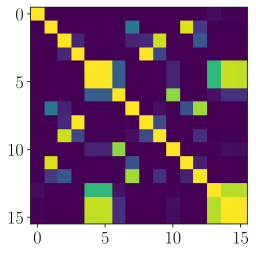

In [6]:
# Kernel
kernel_var = 2
kernel = GPy.kern.RBF(input_dim=1, variance=kernel_var, lengthscale=.5)

# Kernel Gram Matrix
K = kernel.K(X=X, X2=X)
sigma = .01
B = K + sigma * np.eye(K.shape[0])

# Plot
plt.imshow(B)

## GP Inference

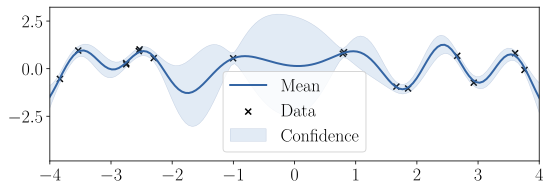

In [4]:
# GP
m = GPy.models.GPRegression(X,Y,kernel)
m.likelihood.variance = sigma
m.plot(figsize=(8, 3), xlim=[x_min, x_max])
plt.show()

## Inference via Probabilistic Numerical Method

 /home/jwenger/Documents/research/probabilistic_numerics/code/probnum/src/probnum/linalg/linearsolvers/matrixbased.py:516: UserWarning:Iteration terminated. Solver reached the maximum number of iterations.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


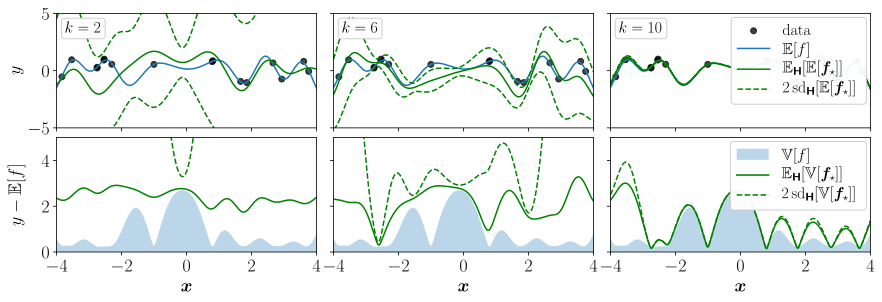

In [5]:
from probnum.linalg import problinsolve
from probnum.linalg.linops import SymmetricKronecker, Identity, ScalarMult
from probnum.prob import RandomVariable, Normal

# Setup and figure
legend_fontsize = 16
maxiter_problinsolve = [2, 6, 10]
fig, axes = plt.subplots(nrows=2, ncols=len(maxiter_problinsolve), 
                         figsize=(4 * len(maxiter_problinsolve), 4), sharex=True, sharey="row", squeeze=False)


# New inputs
nx = 1000
x_new = np.linspace(x_min, x_max, nx)[:, None]
k_new = kernel.K(x_new, X).T

# Linear solver prior
covB = SymmetricKronecker(Identity(n))
Binv0 = RandomVariable(shape=(n, n), 
                      dtype=float, 
                      distribution=Normal(mean=ScalarMult(shape=(n, n), scalar=.1), cov=covB))

# GP mean
GP_mean, GP_margvar = m.predict(x_new)

for i, maxiter in enumerate(maxiter_problinsolve):
        
    # Probabilistic linear solver
    By, Bhat, Binv, info = problinsolve(B, Y, Ainv0=Binv0, maxiter=maxiter)
    
    # Numeric estimate of GP mean with numeric variance
    numeric_GPmean = k_new.T @ By
    numericmean_GPmean = numeric_GPmean.mean()
    numericvar_GPmean = np.diag(numeric_GPmean.cov())
    
    # (Prior) Numeric estimate of GP marginal variance with numeric variance
    numericmean_GPmargvar = np.diag((kernel.K(x_new, x_new) - k_new.T @ (Binv.mean() @ k_new)))
    numericvar_GPmargvar = np.diag((k_new.T @ Binv.cov().A.todense() @ k_new) **2) # follows from distribution of Av : v^T(Av)
 
    # GP mean plot
    axes[0, i].scatter(X, Y, label="data", color="k", alpha=.75) # Data
    axes[0, i].plot(x_new, GP_mean, label="$\mathbb{E}[f]$") # GP mean
    
    axes[0, i].plot(x_new, numericmean_GPmean, label="$\mathbb{E}_{\\bm{\\mathsf{H}}}[\mathbb{E}[\\bm{f}_\\star]]$", color="g") # Computed GP mean
    axes[0, i].plot(x_new, numericmean_GPmean - 2 * np.sqrt(numericvar_GPmean), color="g", 
                    linestyle="--", label="$2 \operatorname{sd}_{\\bm{\\mathsf{H}}}[\mathbb{E}[\\bm{f}_\\star]]$")
    axes[0, i].plot(x_new, numericmean_GPmean + 2 * np.sqrt(numericvar_GPmean), color="g", 
                     linestyle="--") # Numeric uncertainty
    
    anchtext = matplotlib.offsetbox.AnchoredText("$k=" + str(maxiter) + "$",
                      prop=dict(size=legend_fontsize), frameon=True, loc='upper left', pad=0.)
    anchtext.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    anchtext.patch.set_alpha(0.95)
    anchtext.patch.set_edgecolor("0.8")
    axes[0, i].add_artist(anchtext)
    axes[0, i].set_ylim([-5, 5])
    if i == 0:
        axes[0, i].set_ylabel("$y$")#, labelpad=0)
    axes[0, i].margins(x=0)
    
    
    # GP variance plot
    axes[1, i].fill_between(x=x_new.ravel(), y1=np.zeros_like(x_new.ravel()), y2=2 * np.sqrt(GP_margvar.ravel()), 
                            alpha=0.3, label="$\mathbb{V}[f]$") # GP variance
    axes[1, i].plot(x_new, 2 * np.sqrt(numericmean_GPmargvar), label="$\mathbb{E}_{\\bm{\\mathsf{H}}}[\mathbb{V}[\\bm{f}_\\star]]$", 
                    color="g") # Computed GP variance
    axes[1, i].plot(x_new,2 * np.sqrt(numericmean_GPmargvar) + 2 * np.sqrt(numericvar_GPmargvar), 
                    label="$2 \operatorname{sd}_{\\bm{\\mathsf{H}}}[\mathbb{V}[\\bm{f}_\\star]]$", 
                    color="g", linestyle="--") # Variance of computed GP variance
    
    axes[1, i].set_ylim([0, 5])
    if i == 0:
        axes[1, i].set_ylabel("$y-\mathbb{E}[f]$")
    axes[1, i].margins(x=0)
    axes[1, i].set_xlabel("$\\bm{x}$")
    axes[1, i].yaxis.set_label_coords(-.12,.5) # Move label to align with other
        

# Legend
handles, labels = axes[0, 0].get_legend_handles_labels() # reorder legend
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
axes[0, len(maxiter_problinsolve) - 1].legend(handles, labels, loc="upper right", labelspacing=.25, framealpha=.95,
                                              borderaxespad=0.25, fontsize=legend_fontsize)

handles, labels = axes[1, 0].get_legend_handles_labels() # reorder legend
handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]
axes[1, len(maxiter_problinsolve) - 1].legend(handles, labels, loc="upper right", labelspacing=.25, framealpha=.95, 
                                              borderaxespad=0.25, fontsize=legend_fontsize)

# Save to file
plt.tight_layout(pad=0, w_pad=0.75, h_pad=-0.35)
fig.savefig("../figures/gp_regression.pdf", bbox_inches="tight", pad_inches = 0)
plt.show()